In [16]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../Backend/')  # so Python can find the backend module
from ai.utils import preprocess_data 

In [ ]:
# Cell 2: Load your dataset

df = pd.read_csv('../data/dataset_devcamp.csv')
df['week'] = pd.to_datetime(df['week'], errors='coerce')
df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
1,1097,2011-01-17,9672,223153,192.3750,236.5500,1,1,109
2,1096,2011-01-17,9672,223245,207.3375,207.3375,0,0,61
3,1095,2011-01-17,9672,222765,241.5375,241.5375,0,0,49
4,1094,2011-01-17,9672,222087,181.6875,207.3375,1,0,129


In [3]:
# Check if conversion succeeded
print(df['week'].head())
print(df.dtypes)

0   2011-01-17
1   2011-01-17
2   2011-01-17
3   2011-01-17
4   2011-01-17
Name: week, dtype: datetime64[ns]
record_ID                   int64
week               datetime64[ns]
store_id                    int64
sku_id                      int64
total_price               float64
base_price                float64
is_featured_sku             int64
is_display_sku              int64
units_sold                  int64
dtype: object


In [12]:
# Check for nulls or basic stats
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133980 entries, 0 to 133979
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   record_ID        133980 non-null  int64         
 1   week             133980 non-null  datetime64[ns]
 2   store_id         133980 non-null  int64         
 3   sku_id           133980 non-null  int64         
 4   total_price      133980 non-null  float64       
 5   base_price       133980 non-null  float64       
 6   is_featured_sku  133980 non-null  int64         
 7   is_display_sku   133980 non-null  int64         
 8   units_sold       133980 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 9.2 MB


record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [13]:


X = preprocess_data(df)
y = df['units_sold'].values

print(X.shape)



(133980, 111)


In [36]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}') 


Mean Absolute Error: 14.665534019470215


In [ ]:
import pandas as pd

# Load your test set
test_df = pd.read_csv("data/test_final.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/test_final.csv'

Matplotlib is building the font cache; this may take a moment.


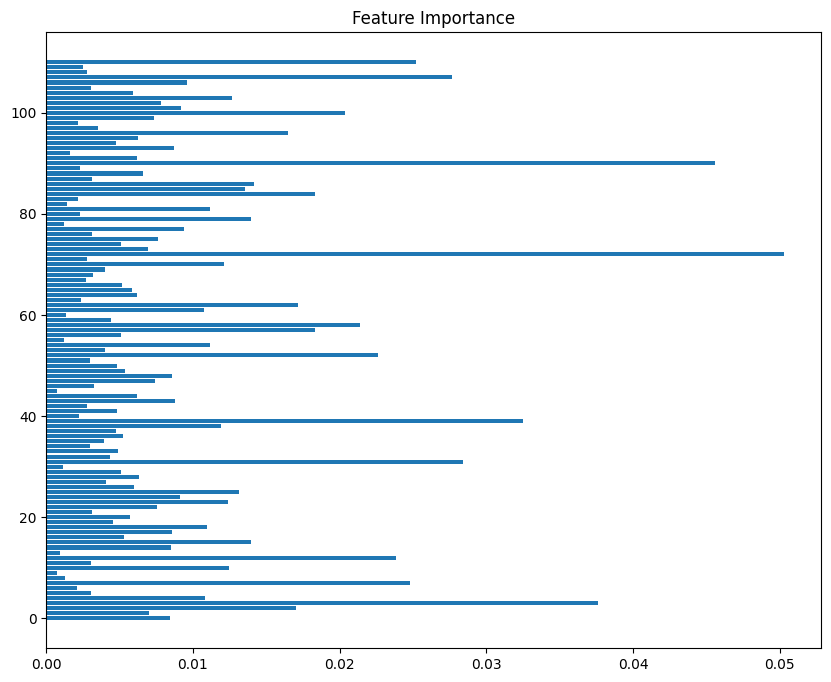

In [19]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(model.feature_importances_.argsort(), model.feature_importances_[model.feature_importances_.argsort()])
plt.title('Feature Importance')
plt.show()


In [20]:
import joblib

# Assuming `model` is your trained model
joblib.dump(model, 'model.pkl')


['model.pkl']

NameError: name 'train_df' is not defined